# Flight Delay Prediction

##  Importing Libraries


In [226]:
import datetime, warnings, scipy  
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

## Getting our data from local device

In [178]:
airlines_data = pd.read_csv('airlines.csv',low_memory = False)
airports_data = pd.read_csv('airports.csv',low_memory = False)
flights_data = pd.read_csv('flights.csv',low_memory = False)

## Explopre Data

In [179]:
airlines_data.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [180]:
airports_data.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [181]:
flights_data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
flights_data['DEPARTURE_DELAY'].max()

1988.0

In [183]:
flights_data.shape

(5819079, 31)

In [184]:
# no of planes diverted = 1
flights_data.value_counts('DIVERTED')

DIVERTED
0    5803892
1      15187
dtype: int64

In [185]:
#getting segement upto 150000 rows of all columns
flights_segment = flights_data[0:150000]

In [186]:
#getting insights from the data
flights_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 150000 non-null  int64  
 1   MONTH                150000 non-null  int64  
 2   DAY                  150000 non-null  int64  
 3   DAY_OF_WEEK          150000 non-null  int64  
 4   AIRLINE              150000 non-null  object 
 5   FLIGHT_NUMBER        150000 non-null  int64  
 6   TAIL_NUMBER          149693 non-null  object 
 7   ORIGIN_AIRPORT       150000 non-null  object 
 8   DESTINATION_AIRPORT  150000 non-null  object 
 9   SCHEDULED_DEPARTURE  150000 non-null  int64  
 10  DEPARTURE_TIME       146099 non-null  float64
 11  DEPARTURE_DELAY      146099 non-null  float64
 12  TAXI_OUT             145976 non-null  float64
 13  WHEELS_OFF           145976 non-null  float64
 14  SCHEDULED_TIME       150000 non-null  float64
 15  ELAPSED_TIME     

In [187]:
#year column is unneccesary since the data is bounded to 2015 but day and month are important
delay =[]
for row in flights_segment['ARRIVAL_DELAY']:
    if row > 60:
        delay.append(3)
    elif row > 30:
        delay.append(2)
    elif row > 15:
        delay.append(1)
    else:
        delay.append(0)  
flights_segment['delay'] = delay

C:\Users\Dell\AppData\Local\Temp/ipykernel_3412/2313183684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_segment['delay'] = delay


In [188]:
# take a look at the basic statistics from selected columns
flights_data.loc[:,['DEPARTURE_TIME', 'DEPARTURE_DELAY',
                  'AIR_TIME', 'DISTANCE', 'ARRIVAL_TIME', 
                  'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED'
                 ]].describe()

,DEPARTURE_TIME,DEPARTURE_DELAY,AIR_TIME,DISTANCE,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
count,5.732926e+06,5.732926e+06,5.714008e+06,5.819079e+06,5.726566e+06,5.714008e+06,5.819079e+06,5.819079e+06
mean,1.335204e+03,9.370158e+00,1.135116e+02,8.223565e+02,1.476491e+03,4.407057e+00,2.609863e-03,1.544643e-02
std,4.964233e+02,3.708094e+01,7.223082e+01,6.077843e+02,5.263197e+02,3.927130e+01,5.102012e-02,1.233201e-01
min,1.000000e+00,-8.200000e+01,7.000000e+00,2.100000e+01,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00
25%,9.210000e+02,-5.000000e+00,6.000000e+01,3.730000e+02,1.059000e+03,-1.300000e+01,0.000000e+00,0.000000e+00
50%,1.330000e+03,-2.000000e+00,9.400000e+01,6.470000e+02,1.512000e+03,-5.000000e+00,0.000000e+00,0.000000e+00
75%,1.740000e+03,7.000000e+00,1.440000e+02,1.062000e+03,1.917000e+03,8.000000e+00,0.000000e+00,0.000000e+00
max,2.400000e+03,1.988000e+03,6.900000e+02,4.983000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00


In [189]:
dropedna = flights_data.dropna(axis=0, how='any', 
                                  subset=['ARRIVAL_DELAY', 'DEPARTURE_DELAY'])

In [190]:
dropedna.shape

(5714008, 31)

In [191]:
flight_new = dropedna.loc[:,['MONTH','DAY','DAY_OF_WEEK',
                           'AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                           'DEPARTURE_DELAY','ARRIVAL_DELAY', 'DISTANCE',
                           'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
                           'LATE_AIRCRAFT_DELAY','WEATHER_DELAY'
                          ]]

In [192]:
flight_new.shape

(5714008, 14)

In [193]:
delayed15min = flight_new.dropna(subset=['AIR_SYSTEM_DELAY','SECURITY_DELAY',
                                        'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY',
                                        'WEATHER_DELAY'], how='all')

In [194]:
delayed15min.shape

(1063439, 14)

In [195]:
flight_new2 = flight_new.drop(['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
                           'LATE_AIRCRAFT_DELAY','WEATHER_DELAY'], axis=1)

In [196]:
flight_new2.shape

(5714008, 9)

In [197]:
# column to measure delay or not
# DELAY_OR_NOT: True (ARRIVAL_DELAY > 0), False (ARRIVAL_DELAY <= 0)

flight_new2['DELAY_OR_NOT'] = flight_new2.loc[:, ['ARRIVAL_DELAY']] > 0
flight_new2.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,ARRIVAL_DELAY,DISTANCE,DELAY_OR_NOT
0,1,1,4,AS,ANC,SEA,-11.0,-22.0,1448,False
1,1,1,4,AA,LAX,PBI,-8.0,-9.0,2330,False
2,1,1,4,US,SFO,CLT,-2.0,5.0,2296,True
3,1,1,4,AA,LAX,MIA,-5.0,-9.0,2342,False
4,1,1,4,AS,SEA,ANC,-1.0,-21.0,1448,False


## Data Analysis and Visualization

In [198]:
# Departure Delay and Arrival_Delay
airlines_data

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [199]:
# merge the fullname of airline companies into flight data
flight_fullname = flight_new2.rename(columns={'AIRLINE': 'IATA_CODE'})
flight_fullname = flight_fullname.merge(airlines_data, on = 'IATA_CODE')

In [200]:
# Make clear on DEPARTURE_DELAY and ARRIVAL_DELAY
# Delay caused before departure or after departure?

airline_deparr_plot = flight_fullname.loc[:, ['AIRLINE', 
                                     'DEPARTURE_DELAY',
                                     'ARRIVAL_DELAY']].groupby('AIRLINE').mean()

In [201]:
airline_deparr_plot

,DEPARTURE_DELAY,ARRIVAL_DELAY
AIRLINE,,
Alaska Airlines Inc.,1.718926,-0.976563
American Airlines Inc.,8.826106,3.451372
American Eagle Airlines Inc.,9.967187,6.457873
Atlantic Southeast Airlines,8.615598,6.585379
Delta Air Lines Inc.,7.313300,0.186754
Frontier Airlines Inc.,13.303352,12.504706
Hawaiian Airlines Inc.,0.469918,2.023093
JetBlue Airways,11.442467,6.677861
Skywest Airlines Inc.,7.736083,5.845652


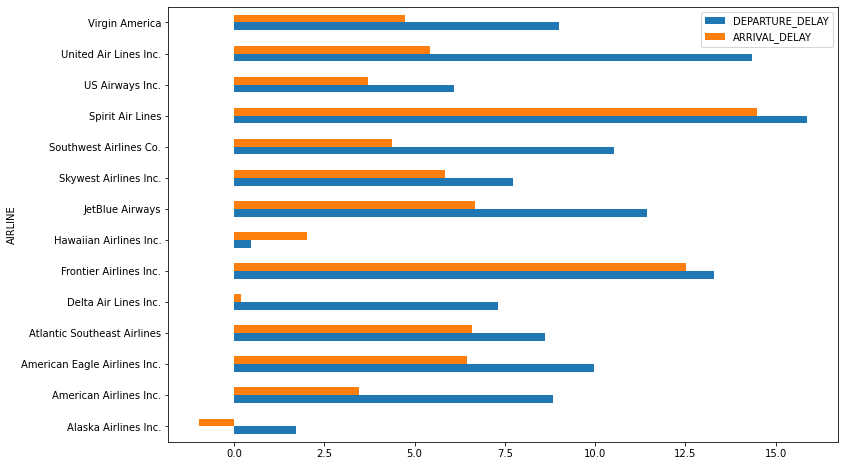

In [202]:
airline_deparr_plot.plot.barh(figsize=(12,8), stacked=False)
plt.show()

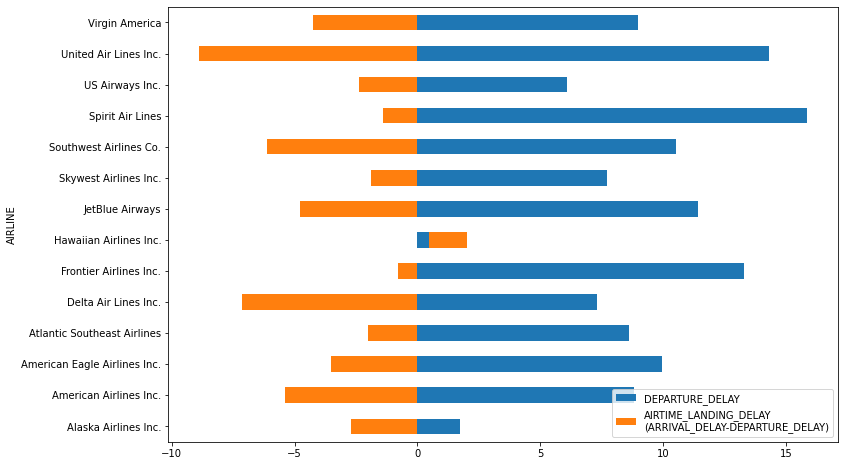

In [203]:
# ARRIVAL_DELAY is the total delay, i.e. delay result of this flight
# extract the delay in the airtime and landing
airline_deparr_plot['ARRIVAL_DELAY'] = (- airline_deparr_plot['DEPARTURE_DELAY'] 
                                        + airline_deparr_plot['ARRIVAL_DELAY'])
ax = airline_deparr_plot.plot.barh(figsize=(12,8), stacked=True)
ax.legend(['DEPARTURE_DELAY', 'AIRTIME_LANDING_DELAY\n(ARRIVAL_DELAY-DEPARTURE_DELAY)'])
# ax.title('')
plt.show()

In [204]:
# use this function to select which airline we are interested
def flight_airline(airline):
    return flight.loc[flight['AIRLINE']==airline]
# draw the number of delays for [what, e.g. MONTH] we want to groupby
def draw_count_delay(data, select, kind='bar'):
    data_select = data.loc[:, [select, 'DELAY_OR_NOT']].groupby(select).sum()
    ax = data_select.plot(kind=kind, figsize=(10,6))
    ax.legend(['Number of Delays'])
    plt.show()

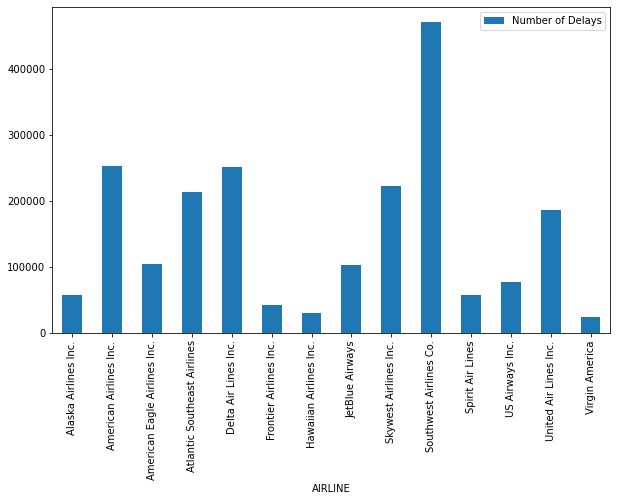

In [205]:
draw_count_delay(flight_fullname, 'AIRLINE')

In [206]:
#let's create more delays
# 0 = On time/ before time/ arrived less than 15 mins of delay
# 1 = more than 15 mins and less than 30 mins of delay
# 2 = more than 30 mins and less than 1 hr of delay
# 3 = more than an hour of delay

delay =[]
for row in flights_segment['ARRIVAL_DELAY']:
    if row > 60:
        delay.append(3)
    elif row > 30:
        delay.append(2)
    elif row > 15:
        delay.append(1)
    else:
        delay.append(0)  
flights_segment['delay'] = delay
    
flights_segment.value_counts('delay')

C:\Users\Dell\AppData\Local\Temp/ipykernel_3412/2251550094.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_segment['delay'] = delay


delay
0    104480
1     15460
3     15397
2     14663
dtype: int64

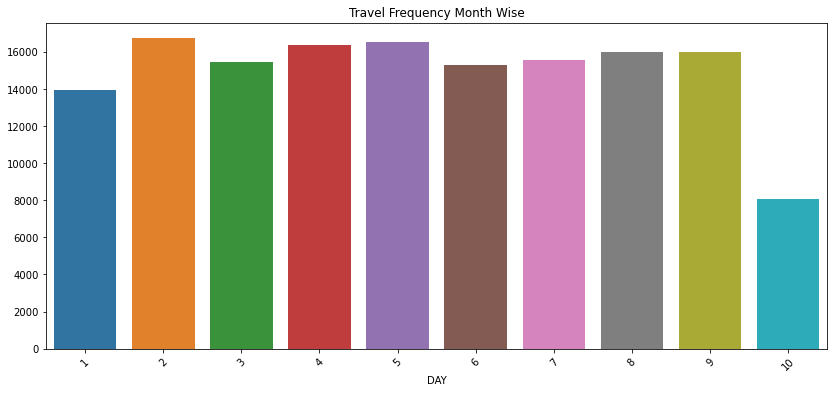

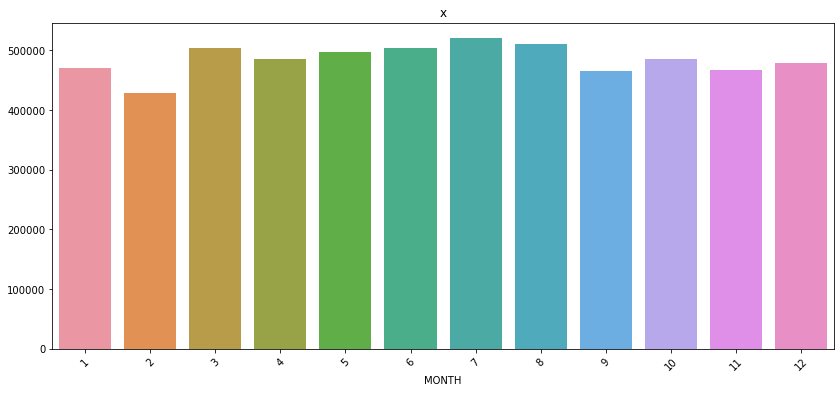

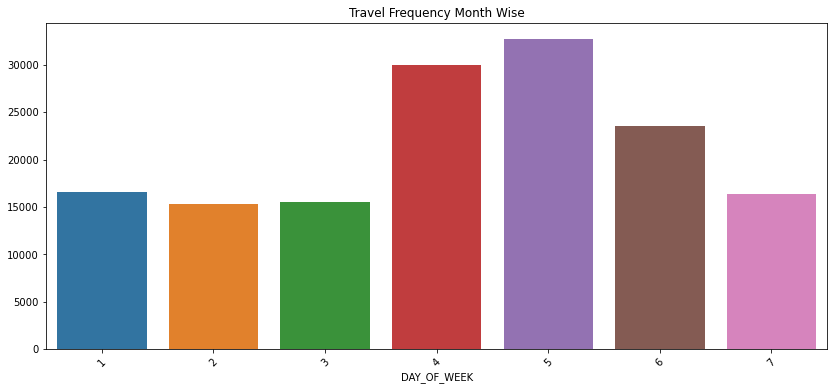

In [207]:
def plot_bar(group, title):
    plt.figure(figsize=(14,6))
    sns.barplot(x=group.index,y=group.values)     
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
plot_bar(flights_segment.value_counts('DAY'), 'Travel Frequency Month Wise')
plot_bar(flights_data.value_counts('MONTH'), 'x')
plot_bar(flights_segment.value_counts('DAY_OF_WEEK'), 'Travel Frequency Month Wise')

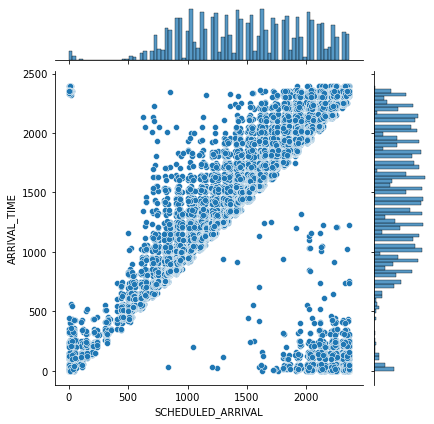

In [208]:
sns.jointplot(data=flights_segment, x="SCHEDULED_ARRIVAL", y="ARRIVAL_TIME")

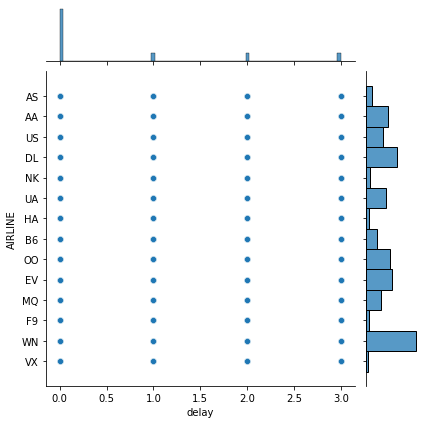

In [209]:
sns.jointplot(data= flights_segment, y= "AIRLINE", x= "delay")

In [210]:
# creating new column that tells if the flight was delayed or not with
# 0 = arrived on time
# 1 = arrived before 15 min
# 2 = delayed 30 min
# 3 = delayed 60 min
Flight_data_delay =[]
for row in flights_data['ARRIVAL_DELAY']:
    if row > 60:
        Flight_data_delay.append(3)
    elif row > 30:
        Flight_data_delay.append(2)
    elif row > 15:
        Flight_data_delay.append(1)
    else:
        Flight_data_delay.append(0)

In [211]:
flights_data['Delay'] = Flight_data_delay

<AxesSubplot:>

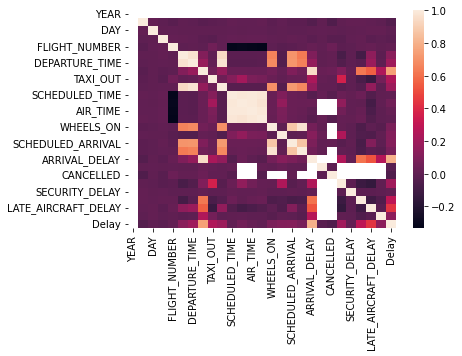

In [212]:
sns.heatmap(flights_data.corr())

In [215]:
#removing unwanted columns
flights_segments=flights_segment.drop(['YEAR','FLIGHT_NUMBER','AIRLINE','DISTANCE','TAIL_NUMBER','TAXI_OUT','SCHEDULED_TIME','DEPARTURE_TIME','WHEELS_OFF','ELAPSED_TIME','AIR_TIME','WHEELS_ON','DAY_OF_WEEK','TAXI_IN','CANCELLATION_REASON','ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', "CANCELLED"], axis=1)

In [216]:
flights_segment.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,delay
count,150000.0,150000.0,150000.000000,150000.000000,150000.000000,150000.000000,146099.000000,146099.000000,145976.000000,145976.000000,...,145821.000000,145557.000000,150000.000000,150000.000000,46924.000000,46924.000000,46924.000000,46924.000000,46924.000000,150000.000000
mean,2015.0,1.0,5.304220,4.219813,2256.395833,1314.443067,1332.752113,18.275683,16.968495,1355.163116,...,1472.515132,16.009405,0.002547,0.027073,13.951837,0.070156,18.098308,25.916631,3.388756,0.606513
std,0.0,0.0,2.729701,1.811923,1814.020525,473.388968,492.526205,45.019483,10.506964,493.282054,...,526.217320,48.092801,0.050400,0.162298,27.088520,1.710421,43.386508,43.367174,19.855894,1.024719
min,2015.0,1.0,1.000000,1.000000,1.000000,5.000000,1.000000,-42.000000,1.000000,1.000000,...,1.000000,-74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,1.0,3.000000,3.000000,759.000000,915.000000,925.000000,-3.000000,11.000000,940.000000,...,1104.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,1.0,5.000000,4.000000,1714.000000,1310.000000,1324.000000,1.000000,14.000000,1337.000000,...,1507.000000,2.000000,0.000000,0.000000,3.000000,0.000000,4.000000,9.000000,0.000000,0.000000
75%,2015.0,1.0,8.000000,6.000000,3455.000000,1715.000000,1734.000000,22.000000,19.000000,1748.000000,...,1912.000000,23.000000,0.000000,0.000000,18.000000,0.000000,19.000000,34.000000,0.000000,1.000000
max,2015.0,1.0,10.000000,7.000000,7438.000000,2359.000000,2400.000000,1380.000000,176.000000,2400.000000,...,2400.000000,1384.000000,1.000000,1.000000,824.000000,107.000000,1380.000000,891.000000,771.000000,3.000000


In [217]:
#replacing all nan values with the mean of the attribute i n wich they are present
flights_segments=flights_segments.fillna(flights_data.mean())

In [235]:
flights_data= flights_segments

In [237]:
flights_segment.head(24)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,delay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,...,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,...,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0


<AxesSubplot:>

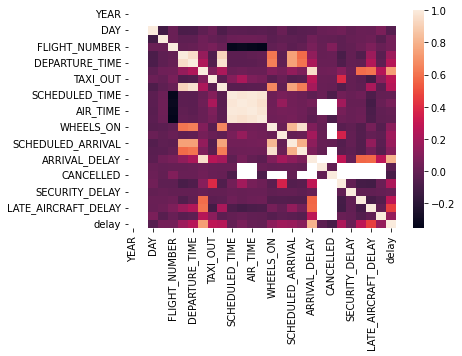

In [238]:
sns.heatmap(flights_segment.corr())

In [239]:
data = flights_data.values
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [240]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [241]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [223]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class='ovr')
auc_score

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## predcitions are 99.8% accurate